In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import findspark
% matplotlib inline

findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import MulticlassMetrics

conf = SparkConf().setMaster("local") \
                  .setAppName("Language Detection") \
                  .set("spark.ui.port", "36000") \
                  .set("spark.executor.memory", "7g") \
                  .set("spark.executor.cores", "2")
            
sc = SparkContext(conf=conf)
sqlCtx = SQLContext(sc)

In [3]:
base_dir = os.path.dirname(os.path.abspath('./Language_Detection_Model/'))
path_data = os.path.join(base_dir, 'txt')
path_train = os.path.join(path_data, 'train.txt')
path_test = os.path.join(path_data, 'test.txt')
path_model = os.path.join(base_dir, 'model')

# index different languages and broadcast the lookup table
langs = [d for d in os.listdir(path_data) if len(d) == 2]
classes = dict(zip(langs, [float(i) for i in range(len(langs))]))
broadcastClasses = sc.broadcast(classes)
broadcastClasses.value

{'bg': 0.0,
 'cs': 1.0,
 'da': 2.0,
 'de': 3.0,
 'el': 4.0,
 'en': 5.0,
 'es': 6.0,
 'et': 7.0,
 'fi': 8.0,
 'fr': 9.0,
 'hu': 10.0,
 'it': 11.0,
 'lt': 12.0,
 'lv': 13.0,
 'nl': 14.0,
 'pl': 15.0,
 'pt': 16.0,
 'ro': 17.0,
 'sk': 18.0,
 'sl': 19.0,
 'sv': 20.0}

In [4]:
def get_nchars(text, nrange=(1, 1)):
    '''
    parameter: text a as single line of text, nrange as the number of chars within word bound
    return: list of chars
    notice: should add parameter check
    '''
    a, b = nrange
    if a == 1:
        nchars = [t for t in text if t != ' ']
    else:
        nchars = []
    for n in range(a, b + 1):
        if n < len(text):
            for i in range(len(text) - n + 1):
                part = text[i:i+n]
                if ' ' not in part:
                    nchars.append(part)
    return nchars


def transform_line(line):
    '''
    parameter: line a as single line of text
    return: tuple of (numerical value of class, list of nchars)
    '''
    label, text = line.split('\t')
    # not able to change the parameter for nrange in the map function
    # take (1, 3) after experiments
    nchars = get_nchars(text, nrange=(1, 3))
    return broadcastClasses.value[label], nchars  # + text.split('\s+')


def read_text_file(fpath):
    '''
    parameter: fpath as the file path to read
    return: Spark data frame
    '''
    # filter out the lines without both label and text
    rdd = sc.textFile(fpath).filter(lambda line: len(line) > 3).map(transform_line)
    df = rdd.toDF(['label', 'ngrams'])
    return df
    
    
trainDF = read_text_file(path_train)    
testDF = read_text_file(path_test)
print 'DataFrame transformation ready.'

DataFrame transformation ready.


In [5]:
def prepare_input_data(trainDF, testDF, numFeatures=1 << 16):
    '''
    parameter: Spark data frame for both training and test, numFeatures as length of tfidf vector
    return: Labeled points ready for the model training
    '''
    # not using spark.ml.pipeline because its not compatible with the model being used
    hashingTF = HashingTF(numFeatures=numFeatures, inputCol='ngrams', outputCol="htf")
    htf_train= hashingTF.transform(trainDF)
    # fit idf model and transform both training and test data
    idf = IDF(minDocFreq=3, inputCol=hashingTF.getOutputCol(), outputCol="features")
    idfModel = idf.fit(htf_train)
    input_train = idfModel.transform(htf_train).map(lambda r: LabeledPoint(r.label, r.features))

    htf_test= hashingTF.transform(testDF)
    input_test = idfModel.transform(htf_test).map(lambda r: LabeledPoint(r.label, r.features))
    # cache the input to save time in model tuning
    input_train.cache()
    input_test.cache()
    return input_train, input_test


input_train, input_test = prepare_input_data(trainDF, testDF, numFeatures=1 << 16)
print 'Input data ready.'

Input data ready.


In [6]:
def train_validate_model(input_train, input_test, iterations=100, regParam=0.01, on_test=False):
    '''
    parameter: Labeled points for training and test, and other parameters for model building
    return: tuple of (model, accuracy, model metrics)
    '''
    if on_test is False:
        split_train, split_valid = input_train.randomSplit([0.8, 0.2], seed=34567)
        lr = LogisticRegressionWithLBFGS.train(split_train, regParam=regParam, regType='l1', \
                                               iterations=iterations, numClasses=len(classes))
        predictions = lr.predict(split_valid.map(lambda lp: lp.features)).map(lambda p: float(p))
        pred_label = predictions.zip(split_valid.map(lambda lp: lp.label))
    else:
        lr = LogisticRegressionWithLBFGS.train(input_train, regParam=regParam, regType='l1', \
                                               iterations=iterations, numClasses=len(classes))
        predictions = lr.predict(input_test.map(lambda lp: lp.features)).map(lambda p: float(p))
        pred_label = predictions.zip(input_test.map(lambda lp: lp.label))

    metrics = MulticlassMetrics(pred_label)
    # print out the metrics
    acc = pred_label.map(lambda t: 1 if t[0] == t[1] else 0).reduce(lambda x, y: x + y) / float(pred_label.count())
    print "---------------------------------------------------------------------"
    print "Model Parameters - iterations: {0:0.5f}, regParam: {1:0.5f}".format(iterations, regParam)
    print "Accuracy on test data: {}".format(acc)
    f_score = metrics.weightedFMeasure()
    print "Weighted f_score: {}".format(f_score)
    return lr, metrics


def plot_confusion_matrix(metrics):
    '''
    parameter: accuracy and metrics for model
    '''
    cm = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(21, 21))
    sns.heatmap(cm, annot=True,  fmt='', xticklabels=langs, yticklabels=langs);
    plt.title('Confusion Matrix for Languages')
    plt.show()

---------------------------------------------------------------------
Model Parameters - iterations: 100.00000, regParam: 0.00800
Accuracy on test data: 0.994666666667
Weighted f_score: 0.99466715771
---------------------------------------------------------------------
Model Parameters - iterations: 100.00000, regParam: 0.01000
Accuracy on test data: 0.991476190476
Weighted f_score: 0.991473587904
---------------------------------------------------------------------
Model Parameters - iterations: 120.00000, regParam: 0.00800
Accuracy on test data: 0.994666666667
Weighted f_score: 0.99466715771
---------------------------------------------------------------------
Model Parameters - iterations: 120.00000, regParam: 0.01000
Accuracy on test data: 0.991476190476
Weighted f_score: 0.991473587904
---------------------------------------------------------------------
Model Parameters - iterations: 150.00000, regParam: 0.00800
Accuracy on test data: 0.994666666667
Weighted f_score: 0.9946671577

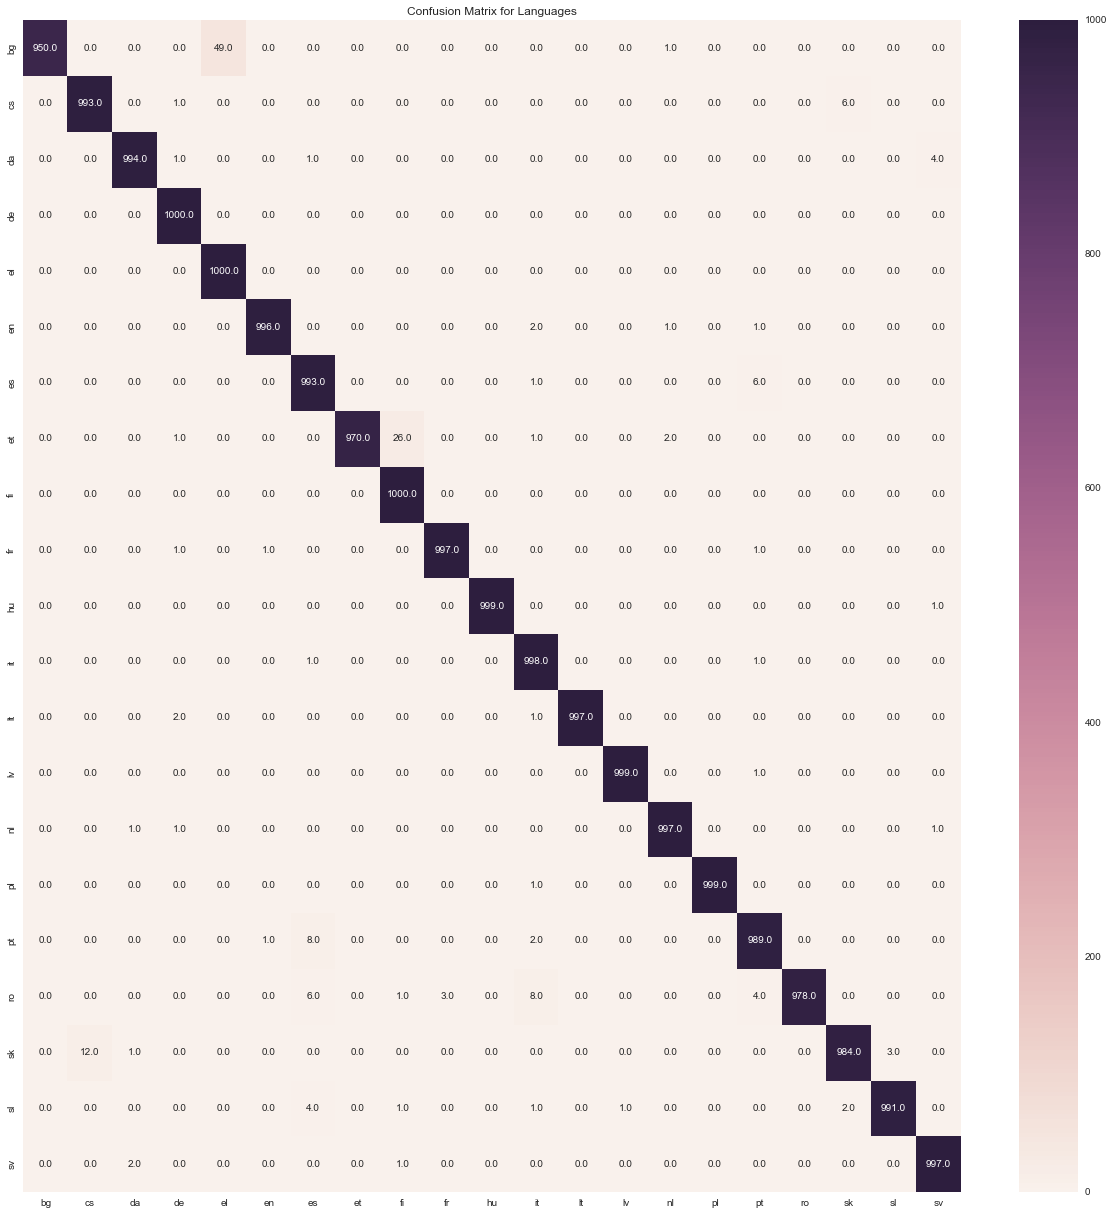

In [7]:
def tune_model(iterations_range, regParam_range):
    '''
    Grid parameter tuning and result showing
    '''
    best_model = None
    metrics_of_best_model = None
    highest_accuracy = float('-inf')
    highest_f_score = float('-inf')

    for iterations in iterations_range:
        for regParam in regParam_range:
            model, metrics = train_validate_model(input_train, input_test, 
                                                  iterations=iterations, regParam=regParam, on_test=True)
            f_score = metrics.weightedFMeasure()
            if f_score > highest_f_score:
                best_model = model
                metrics_of_best_model = metrics
    plot_confusion_matrix(metrics_of_best_model)
    return best_model


# of course, there are already experiments on the parameters, but still, more parameters can be chosen in a bigger cluster
best_model = tune_model(iterations_range=[100, 120, 150], regParam_range=[0.008, 0.01])
best_model.save(sc, base_dir)